<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/final_diabetes_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


In [24]:
#Load all pickled data
KNN_imputed_trainX = pickle.load(open("KNN_imputed_trainX_70.pkl", "rb"))
KNN_imputed_testX_df = pickle.load(open("KNN_imputed_testX_df_70.pkl", "rb"))
train_y = pickle.load(open("diabetes_train_y.pkl", "rb"))
test_y = pickle.load(open("diabetes_test_y.pkl", "rb"))

pca_95per_train = pickle.load(open("pca_95per_train_70.pkl", "rb"))
pca_97per_train = pickle.load(open("pca_97per_train_70.pkl", "rb"))
pca_99per_train = pickle.load(open("pca_99per_train_70.pkl", "rb"))

pca_95per_test = pickle.load(open("pca_95per_test_70.pkl", "rb"))
pca_97per_test = pickle.load(open("pca_97per_test_70.pkl", "rb"))
pca_99per_test = pickle.load(open("pca_99per_test_70.pkl", "rb"))

In [5]:
#standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(KNN_imputed_trainX)
scaled_test_df = scaler.fit_transform(KNN_imputed_testX_df)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score
RF_Cl=RandomForestClassifier(n_estimators=200)
start = time.time()
RF_Cl.fit(scaled_df,train_y) #training
end = time.time()
print("Time taken to train data with RFC in seconds :",end-start)

Time taken to train data with RFC in seconds : 194.90589928627014


In [ ]:
RF_Cl.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [ ]:
y_pred = RF_Cl.predict(scaled_test_df) #predicting on the test set

In [ ]:
from sklearn import metrics
rfc_test_score = metrics.accuracy_score(test_y, y_pred)
print("Accuracy of RFC model:",rfc_test_score)

Accuracy of RFC model: 0.7715888137676705


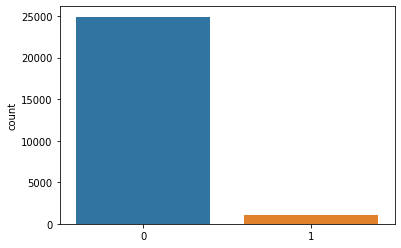

In [ ]:
sns.countplot(y_pred)

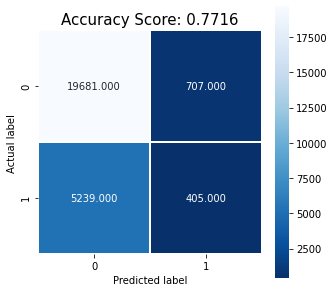

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(rfc_test_score)
plt.title(all_sample_title, size = 15);

# XGB

In [ ]:
xg_cl = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xg_cl.fit(scaled_df,train_y)
preds = xg_cl.predict(scaled_test_df)

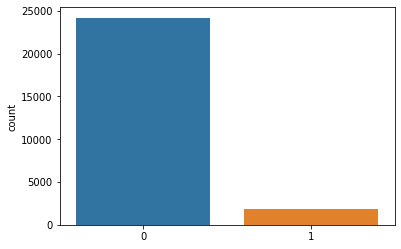

In [ ]:
sns.countplot(preds)

In [ ]:
from sklearn import metrics
xgb_accuracy = metrics.accuracy_score(test_y, preds)
print("Accuracy of XGB model:",xgb_accuracy)

Accuracy of XGB model: 0.7575676090964967


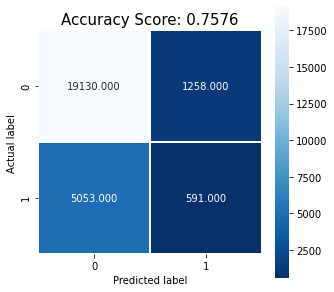

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(xgb_accuracy)
plt.title(all_sample_title, size = 15);

# Light GBM

In [ ]:
clf = lgb.LGBMClassifier(n_estimators=100)
%time clf.fit(scaled_df, train_y)

CPU times: user 13.8 s, sys: 264 ms, total: 14.1 s
Wall time: 14.1 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# predict the results
lgb_y_pred=clf.predict(scaled_test_df)

In [ ]:
lgb_accuracy=accuracy_score(lgb_y_pred, test_y)
print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_accuracy))

LightGBM Model accuracy score: 0.7330


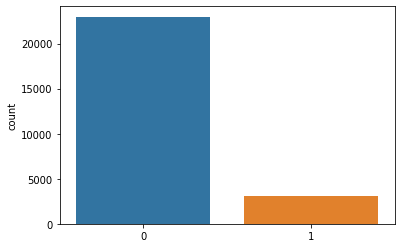

In [ ]:
sns.countplot(lgb_y_pred)

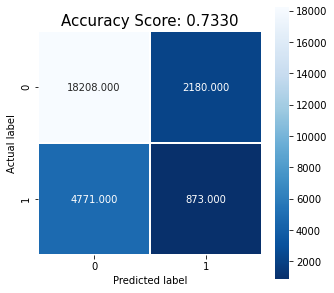

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, lgb_y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(lgb_accuracy)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, lgb_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84     20388
           1       0.29      0.15      0.20      5644

    accuracy                           0.73     26032
   macro avg       0.54      0.52      0.52     26032
weighted avg       0.68      0.73      0.70     26032



# Keras Classifier

In [ ]:
KNN_imputed_trainX

,age,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,albumin_apache,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,...,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min
115201,60.000000,40.234881,2.0,1.0,185.4,8.0,2.0,0.096528,138.3,2.400000,1208.0,1.0,0.0,0.300000,94.000000,7.070000,4.0,6.0,0.0,5.0,51.000000,58.0,21.800000,0.0,59.0,12.0,134.0,35.0,4690.65600,0.0,16.200000,90.0,44.0,90.0,44.0,71.0,60.0,96.0,60.0,96.0,...,35.000000,35.000000,2.600000,2.400000,0.300000,0.300000,94.0,89.0,7.8,7.5,7.07,6.08,171.0,52.0,18.0,16.0,7.8,6.8,24.2,21.8,1.000000,1.000000,325.0,309.0,5.0,4.1,138.0,134.0,16.20,12.90,106.000000,52.000000,1.000000,1.000000,46.516667,38.010000,7.380233,7.310033,146.210000,92.786667
5903,73.000000,30.100790,2.0,1.0,175.3,8.0,2.0,0.000694,92.5,2.803333,1205.0,1.0,0.0,2.147667,21.000000,0.910000,4.0,6.0,0.0,5.0,200.000000,120.0,39.600000,0.0,122.0,43.0,138.0,36.4,1604.41632,0.0,15.100000,98.0,57.0,98.0,57.0,127.0,86.0,122.0,77.0,122.0,...,36.700000,36.700000,2.833333,2.793333,2.107667,2.090333,21.0,20.0,8.7,8.5,0.98,0.91,200.0,114.0,24.0,24.0,13.9,13.1,42.1,39.6,1.281667,1.223667,120.0,112.0,4.4,3.9,138.0,138.0,15.10,14.30,115.000000,115.000000,1.281667,1.223667,39.000000,39.000000,7.380000,7.380000,68.000000,68.000000
68265,70.000000,15.500031,2.0,1.0,177.8,15.0,1.0,0.604861,49.0,2.933333,703.0,0.0,0.0,0.984667,25.186667,1.442667,4.0,6.0,0.0,5.0,121.333333,104.0,32.946667,0.0,120.0,60.0,138.7,36.2,5879.77920,0.0,12.029333,96.0,76.0,96.0,76.0,96.0,62.0,110.0,82.0,110.0,...,37.247333,36.957333,3.200000,3.200000,0.600000,0.600000,5.0,5.0,8.6,8.6,0.48,0.48,107.0,104.0,23.0,22.6,12.1,12.1,36.0,36.0,1.705667,1.509000,107.0,107.0,3.5,3.5,139.0,139.0,10.90,10.90,127.366667,121.766667,1.705667,1.509000,38.873333,33.613333,7.386300,7.316733,148.576667,96.943333
109489,68.000000,28.069727,5.0,1.0,182.9,15.0,0.0,0.188889,93.9,2.983333,104.0,0.0,0.0,1.103333,20.000000,1.550000,4.0,6.0,0.0,5.0,105.000000,139.0,33.900000,0.0,189.0,35.0,132.0,36.3,5067.61920,0.0,7.600000,94.0,72.0,94.0,72.0,137.0,70.0,184.0,86.0,181.0,...,36.300000,36.300000,2.953333,2.943333,1.110000,1.063333,20.0,20.0,8.6,8.6,1.55,1.55,105.0,105.0,27.0,27.0,11.5,11.5,33.9,33.9,1.361000,1.327667,116.0,116.0,3.4,2.8,132.0,132.0,7.60,7.60,172.433333,168.800000,1.361000,1.327667,43.000000,36.000000,7.500000,7.450000,138.000000,78.000000
14762,51.000000,30.722940,3.0,0.0,167.6,3.0,0.0,0.059722,86.3,2.890000,201.0,0.0,0.0,0.703333,27.000000,0.680000,2.0,5.0,0.0,3.0,93.000000,139.0,29.700000,1.0,46.0,33.0,136.0,36.1,973.72800,1.0,27.410000,67.0,40.0,67.0,40.0,128.0,96.0,78.0,51.0,78.0,...,36.700000,36.700000,2.953333,2.923333,0.679667,0.663000,27.0,27.0,9.2,9.2,0.68,0.68,118.0,93.0,26.0,26.0,9.7,9.7,29.7,29.7,1.361667,1.338000,347.0,347.0,4.7,4.7,136.0,136.0,27.41,27.41,141.466667,140.300000,1.361667,1.338000,51.900000,48.700000,7.374000,7.353000,57.400000,57.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
nn_model = Sequential()

# Add an input layer 
nn_model.add(Dense(109, activation='relu', input_dim=109))

# Add two hidden layers 
nn_model.add(Dense(50, activation='relu'))
nn_model.add(Dense(20, activation='relu'))

# Add an output layer 
nn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model output shape
nn_model.output_shape

# Model summary
nn_model.summary()

# Model config
nn_model.get_config()

# List all weight tensors 
nn_model.get_weights()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 109)               11990     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5500      
_________________________________________________________________
dense_14 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 21        
Total params: 18,531
Trainable params: 18,531
Non-trainable params: 0
_________________________________________________________________


[array([[-0.10893019,  0.00933069, -0.06603468, ..., -0.06644343,
         -0.00265765,  0.14657325],
        [ 0.11557436,  0.1046901 ,  0.16127333, ..., -0.1616711 ,
          0.01780488,  0.10650241],
        [-0.07583273, -0.04949469,  0.10270509, ..., -0.12740332,
          0.12605643, -0.02858691],
        ...,
        [-0.02617133, -0.11960812, -0.02263221, ..., -0.05959561,
         -0.05953363,  0.1290426 ],
        [-0.00810535,  0.13591006, -0.00265038, ..., -0.15300752,
          0.11938947,  0.11993384],
        [-0.01868938, -0.04224426, -0.14274234, ..., -0.15042122,
          0.09989607, -0.06558381]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
nn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
%time nn_model.fit(scaled_df, train_y, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
104125/104125 [==============================] - 163s 2ms/step - loss: 0.4243 - accuracy: 0.8105
Epoch 2/20
104125/104125 [==============================] - 164s 2ms/step - loss: 0.3962 - accuracy: 0.8213
Epoch 3/20
104125/104125 [==============================] - 164s 2ms/step - loss: 0.3887 - accuracy: 0.8247
Epoch 4/20
104125/104125 [==============================] - 164s 2ms/step - loss: 0.3851 - accuracy: 0.8262
Epoch 5/20
104125/104125 [==============================] - 164s 2ms/step - loss: 0.3849 - accuracy: 0.8265
Epoch 6/20
104125/104125 [==============================] - 162s 2ms/step - loss: 0.3816 - accuracy: 0.8278
Epoch 7/20
104125/104125 [==============================] - 161s 2ms/step - loss: 0.3808 - accuracy: 0.8298
Epoch 8/20
104125/104125 [==============================] - 159s 2ms/step - loss: 0.3791 - accuracy: 0.8319
Epoch 9/20
104125/104125 [==============================] - 159s 2ms/step - loss: 0.3765 - accuracy: 0.8330
Epoch 10/20
104125/104125 [=

In [ ]:
%time nn_y_pred= nn_model.predict_classes(scaled_test_df)
pickle.dump(nn_y_pred, open("nn_y_pred.pkl", "wb"))  

CPU times: user 613 ms, sys: 58.6 ms, total: 672 ms
Wall time: 559 ms


In [ ]:
nn_y_pred = pickle.load(open("nn_y_pred.pkl", "rb"))
nn_y_pred = nn_y_pred.flatten()

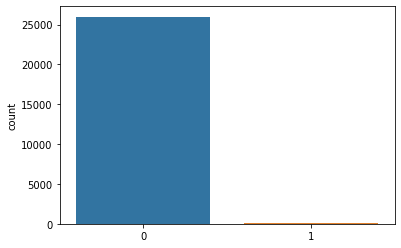

In [ ]:
sns.countplot(nn_y_pred)

In [ ]:
nn_scores = nn_model.evaluate(scaled_test_df, test_y, verbose=0)
print('Accuracy on test data: {}'.format(nn_scores[1]))  

Accuracy on test data: 0.7822679877281189


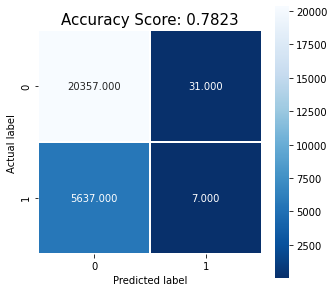

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, nn_y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(nn_scores[1])
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(test_y, nn_y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     20388
           1       0.18      0.00      0.00      5644

    accuracy                           0.78     26032
   macro avg       0.48      0.50      0.44     26032
weighted avg       0.65      0.78      0.69     26032



#Logistic Regression

Accuracy on test data: 0.7377842655193608


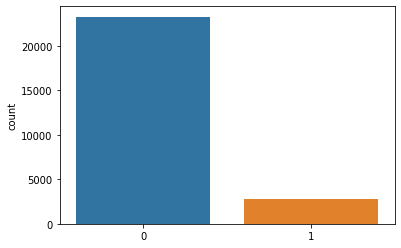

In [6]:
# Apply logistic regression
clf = LogisticRegression(random_state=0, max_iter=200).fit(scaled_df, train_y)
pred = clf.predict(scaled_test_df)
score = clf.score(scaled_test_df,test_y)
print('Accuracy on test data: {}'.format(score))  
sns.countplot(pred)


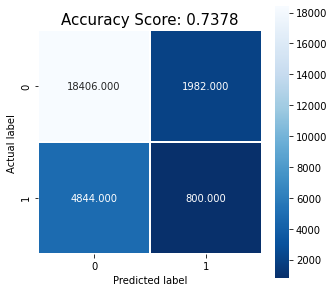

In [10]:
#show confusion matrix
cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(score)
plt.title(all_sample_title, size = 15);

In [13]:
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84     20388
           1       0.29      0.14      0.19      5644

    accuracy                           0.74     26032
   macro avg       0.54      0.52      0.52     26032
weighted avg       0.68      0.74      0.70     26032



In [11]:
# Hyperparameter tuning
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter = [200,300]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = max_iter)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
grid_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(scaled_df, train_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.811803 using {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 10}
0.811693 (0.001834) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
0.811798 (0.001823) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 300, 'C': 1.0}
0.811717 (0.001738) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
0.811693 (0.001834) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 0.01}
0.811794 (0.001823) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'C': 100}
0.811789 (0.001818) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 10}
0.811717 (0.001852) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 0.1}
0.811803 (0.001823) with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 10}
0.811794 (0.001823) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 100}
0.811803 (0.001811) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 30

## Logistic Regression on PCA data

In [25]:
lgreg_pca = LogisticRegression(max_iter=200)
scaler = StandardScaler()
pca_97per_train_scaled = scaler.fit_transform(pca_97per_train)
pca_97per_test_scaled = scaler.fit_transform(pca_97per_test)
%time lgreg_pca.fit(pca_97per_train_scaled, train_y)

CPU times: user 376 ms, sys: 121 ms, total: 498 ms
Wall time: 278 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# predict the results
lgreg_pca_y_pred=lgreg_pca.predict(pca_97per_test_scaled)
lgreg_pca_accuracy=accuracy_score(lgreg_pca_y_pred, test_y)
print('Logistic Regression Model accuracy score: {0:0.4f}'.format(lgreg_pca_accuracy))

Logistic Regression Model accuracy score: 0.8049


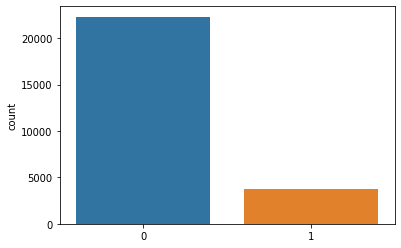

In [30]:
sns.countplot(lgreg_pca_y_pred)


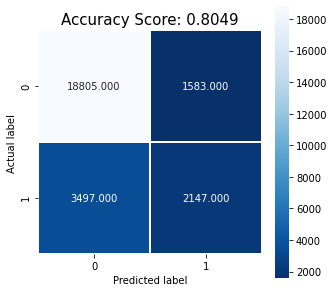

In [32]:
#show confusion matrix
cm = confusion_matrix(test_y, lgreg_pca_y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(lgreg_pca_accuracy)
plt.title(all_sample_title, size = 15);